# MNIST-CIFAR Dominoes

Samples are vertical concatenations of MNIST digits and CIFAR-10 images, based on [Shah et al. (2020)](https://proceedings.neurips.cc/paper/2020/file/6cfe0e6127fa25df2a0ef2ae1067d915-Paper.pdf). 

Unlike the original paper, we occasionally omit one of the two images, which is controlled by the parameters $p_\text{mnist}$ and $p_\text{cifar} (the probability of including only the corresponding "pattern"), where $p_\text{mnist} + p_\text{cifar} < 1$.

In [14]:
!pip3 install numpy torch torchvision einops matplotlib tqdm jupyter ipywidgets torchtyping wandb scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 12.3 MB/s eta 0:00:0000:0100:01


In [12]:
import sys
import logging
import random
from dataclasses import dataclass
import itertools

import torch as t
import numpy as np
import torchvision
import einops
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torchtyping import TensorType
from scipy.optimize import linprog

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import wandb

wandb.login()

True

: 

In [3]:
# Load the datasets (MNIST and CIFAR-10)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Turn both datasets into dominoes (i.e., 64x32x3 images).
# For MNIST, this means adding padding and extra channels (which are just a copy).
# (so that it has the same number of channels as CIFAR-10).
# Put MNIST at the top of the domino and CIFAR-10 at the bottom.

from typing import Union


def mnist_to_domino(mnist: TensorType["b", 28, 28]) -> TensorType["b", 3, 32, 32]:
    mnist = mnist.data.unsqueeze(1).float()
    mnist = t.nn.functional.pad(mnist, (2, 2, 2, 34))
    mnist = mnist.repeat(1, 3, 1, 1)
    return mnist


def cifar_to_domino(cifar: Union[np.ndarray, t.Tensor]) -> TensorType["b", 3, 32, 32]:
    cifar = t.tensor(cifar).float()
    cifar = t.nn.functional.pad(cifar, (0, 0, 0, 0, 32, 0))

    cifar = einops.rearrange(cifar, 'b h w c -> b c h w')
    return cifar

Dataset_ = Union[torchvision.datasets.MNIST, torchvision.datasets.CIFAR10]

def sort_by_label(data: Dataset_, n_labels: int = 10):
    # Assumes 10 labels
    data_by_label = [[] for _ in range(n_labels)]
    
    for image, label in zip(data.data, data.targets):
        data_by_label[label].append(t.tensor(image))

    data_by_label = [t.stack(images) for images in data_by_label]

    return data_by_label


@dataclass
class DominoesConfig:
    # Prevalence
    r_mnist_to_cifar: float = 1.0
    p_both: float = 0.5

    # Reliability
    p_mnist_error: float = 0.0
    p_cifar_error: float = 0.0

    # Miscellaneous
    seed: int = 0
    shuffle: bool = True    

    def get_sampling_sizes(self, n_mnist: int, n_cifar: int):
        c = np.array([1, 0, 0, 1, 0, 0])
        A_eq = np.array([
            [1, 1, 1, 0, 0, 0],
            [0, 0, 0, 1, 1, 1],
            [0, 0, 1, 0, 0, -1],
            [0, 1, 1, 0, -self.r_mnist_to_cifar, -self.r_mnist_to_cifar],
            [0, -self.p_both, 1, 0, -self.p_both, -self.p_both]
        ])
        b_eq = np.array([n_mnist, n_cifar, 0, 0, 0])

        bounds = [*((0, n_mnist) for _ in range(3)), *((0, n_cifar) for _ in range(3))]

        res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

        print(res.message)

        return np.round(res.x).astype(int)

    @property
    def p_mnist_only(self):
        return 1 - self.p_both - self.p_cifar_only
    
    @property
    def p_cifar_only(self):
        return (1 - self.p_both) / (1 + self.r_mnist_to_cifar)
    
    @property
    def p_mnist(self):
        return self.p_both + self.p_mnist_only
    
    @property
    def p_cifar(self):
        return self.p_both + self.p_cifar_only

    @property
    def p_drop(self):
        return 2 - self.p_mnist - self.p_cifar

class Dominoes(Dataset):
    def __init__(self, mnist: torchvision.datasets.MNIST, cifar: torchvision.datasets.CIFAR10, config: DominoesConfig):
        self.dominoes = self.create_dominoes(mnist, cifar, config)

    def __len__(self):
        return len(self.dominoes)

    def __getitem__(self, idx):
        return self.dominoes[idx]

    def create_dominoes(self, mnist: torchvision.datasets.MNIST, cifar: torchvision.datasets.CIFAR10, config: DominoesConfig):
        t.manual_seed(config.seed)

        mnist_by_label = [mnist_to_domino(images) for images in sort_by_label(mnist)]
        cifar_by_label = [cifar_to_domino(images) for images in sort_by_label(cifar)]

        dominoes = []

        for i, (mnist_i, cifar_i) in enumerate(zip(mnist_by_label, cifar_by_label)):
            dominoes_i, domino_types_i = self.create_dominoes_for_class(mnist_i, cifar_i, config)
            labels = t.full((dominoes_i.shape[0],), i)
            
            for image, label, domino_type in zip(dominoes_i, labels, domino_types_i):
                # TODO: More efficient way to do this?
                dominoes.append((image, label, domino_type))

        # dominoes = self.apply_swap_errors(dominoes, config)
        
        domino_types = [domino_type for _, _, domino_type in dominoes]
        domino_type_fractions = [domino_types.count(i) / len(domino_types) for i in range(3)]

        print(f"Domino type fractions: {domino_type_fractions}")

        if config.shuffle:
            # Currently you will always get the same dominoes (even if shuffle is True)
            random.shuffle(dominoes)

        return dominoes
    
    @staticmethod
    def create_dominoes_for_class(mnist: t.Tensor, cifar: t.Tensor, config: DominoesConfig):
        """Helper function for create_dominoes that only creates the dominoes for a single class."""
        n_mnist = mnist.shape[0]
        n_cifar = cifar.shape[0]

        _, n_mnist_1, n_mnist_2, _, n_cifar_1, n_cifar_2 = config.get_sampling_sizes(n_mnist, n_cifar)

        mnist = mnist[t.randperm(n_mnist)]
        cifar = cifar[t.randperm(n_cifar)]  # Relative order doesn't matter bc they have the same label    

        mnist_only = mnist[:n_mnist_1]
        cifar_only = cifar[:n_cifar_1]

        mnist_both = mnist[n_mnist_1:n_mnist_1 + n_mnist_2]
        cifar_both = cifar[n_cifar_1:n_cifar_1 + n_cifar_2]

        doubles = mnist_both + cifar_both  # They've already been padded

        dominoes = t.cat([mnist_only, cifar_only, doubles])
        domino_types = t.cat([t.zeros(n_mnist_1), t.ones(n_cifar_1), t.full((n_cifar_2,), 2)])

        return dominoes, domino_types

    def apply_swap_errors(self, dominoes: list[tuple[t.Tensor, int, int]], config: DominoesConfig):
        n_dominoes = len(dominoes)

        n_mnist_errors = int(n_dominoes * config.p_mnist_error)
        mnist_indices_origins = t.randperm(n_dominoes)[:n_mnist_errors]
        mnist_indices_targets = mnist_indices_origins.roll(1)

        for origin, target in zip(mnist_indices_origins, mnist_indices_targets):
            dominoes[origin][0][0, :, 32:], dominoes[target][0][0, :, 32:] = dominoes[target][0][0, :, 32:], dominoes[origin][0][0, :, 32:]

        if config.p_mnist_error > 0:
            for i in range(5):
                plt.imshow(einops.rearrange(dominoes[mnist_indices_origins[i]][0].int().numpy(), "c h w -> h w c"),)
                plt.show()

        n_cifar_errors = int(n_dominoes * config.p_cifar_error)
        cifar_indices_origins = t.randperm(n_dominoes)[:n_cifar_errors]
        cifar_indices_targets = cifar_indices_origins.roll(1)

        for origin, target in zip(cifar_indices_origins, cifar_indices_targets):
            dominoes[origin][0][0, :, 32:], dominoes[target][0][0, :, 32:] = dominoes[target][0][0, :, 32:], dominoes[origin][0][0, :, 32:]

        return dominoes

In [5]:
dominoes_train = Dominoes(mnist_train, cifar_train, DominoesConfig(p_both=0.3, r_mnist_to_cifar=2))
dominoes_test = Dominoes(mnist_test, cifar_test, DominoesConfig())

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_22710/1049975635.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_by_label[label].append(t.tensor(image))
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_22710/1049975635.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cifar = t.tensor(cifar).float()


Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Domino type fractions: [0.5666844819367606, 0.13332562943275217, 0.2999898886304872]
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimization termin

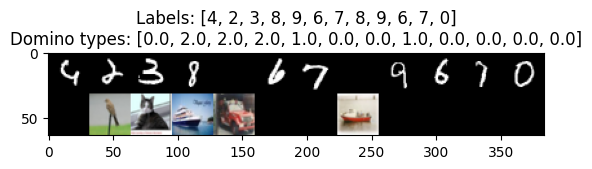

In [6]:
def preview_dominoes(data: Dominoes, n: int = 12):
    # Randomly sample n entries from the dataset 
    samples = random.sample([e for e in data], n)
    items, labels, domino_types = zip(*samples)
        
    # Combine the dominoes into a single image
    items = t.stack(items)
    items = einops.rearrange(items, '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=1)

    items = items.int()

    plt.title(f"Labels: {[l.item() for l in labels]}\nDomino types: {[dt.item() for dt in domino_types]}")
    plt.imshow(items)
        
preview_dominoes(dominoes_train)

In [10]:
dominoes_train_loader = DataLoader(dominoes_train, batch_size=64, shuffle=True)
dominoes_test_loader = DataLoader(dominoes_test, batch_size=64, shuffle=True)

In [7]:
class DominoDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        # self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # self.conv3 = nn.Conv2d(64, 128, 3, 1)
        
        # self.fc1 = nn.Linear(128 * 6 * 6, 128)
        self.fc1 = nn.Linear(32 * 15 * 31, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.conv3(x)
        # x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = t.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        with t.no_grad():
            x = self.forward(x)
            return F.log_softmax(x, dim=1)
        

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out

class ResNet8(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet8, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = nn.Sequential(
            ResNetBlock(16, 16),
            ResNetBlock(16, 16)
        )
        self.layer2 = nn.Sequential(
            ResNetBlock(16, 32, stride=2),
            ResNetBlock(32, 32)
        )
        self.layer3 = nn.Sequential(
            ResNetBlock(32, 64, stride=2),
            ResNetBlock(64, 64)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def predict(self, x):
        with t.no_grad():
            x = self.forward(x)
            return F.log_softmax(x, dim=1)

In [8]:
class ExtendedDataLoader(DataLoader[Dominoes]):
    @property
    def num_samples(self):
        return len(self.dataset)  # type: ignore

    @property
    def num_batches(self):
        return len(self)  # type: ignore


class DataLoaders:
    """
    A wrapper around a dictionary of dataLoaders.
    Assumes, at minimum, a "train" and "test" dataLoader.

    TODO: Allow different configurations for different dataLoaders
    """

    def __init__(self, datasets: dict[str, Dominoes] | tuple[Dominoes, Dominoes], **kwargs):
        if isinstance(datasets, tuple):
            self.datasets = {"train": datasets[0], "test": datasets[1]}
        else:
            self.datasets = datasets

        self.loaders = {
            name: ExtendedDataLoader(
                dataset,
                **kwargs
            ) for name, dataset in self.datasets.items()
        }
    
    def __getitem__(self, key: str):
        return self.loaders[key]
    
    def __iter__(self):
        return iter(self.loaders.items())

    @property
    def train(self):
        return self.loaders["train"]
    
    @property
    def test(self):
        return self.loaders["test"]


@dataclass
class DatasetMetrics:
    loss: TensorType["measurements"]
    accuracy: TensorType["measurements"]
    loss_by_type: TensorType["measurements", "types"]
    accuracy_by_type: TensorType["measurements", "types"]
    loader: ExtendedDataLoader[Dominoes]
    name: str

    def __init__(self, n_measurements: int, n_types: int, loader: ExtendedDataLoader, name: str):
        self.loss = t.zeros(n_measurements)
        self.accuracy = t.zeros(n_measurements)
        self.loss_by_type = t.zeros(n_measurements, n_types)
        self.accuracy_by_type = t.zeros(n_measurements, n_types)
        self.loader = loader
        self.name = name

    @property
    def dataset(self):
        return self.loader.dataset
    
    @staticmethod
    def count_per_type(loader: DataLoader):
        n_per_type = t.zeros(3)
        for (_, _, domino_types) in loader:
            for domino_type in range(3):
                n_per_type[domino_type] += (domino_types==domino_type).sum()

        return n_per_type
    
    @property
    def num_samples(self):
        return len(self.dataset)  # type: ignore

    @property
    def num_samples_per_type(self):
        return self.count_per_type(self.loader)
    
    def measure_batch(self, measurement: int, loss_by_type: TensorType["b", "types"], correct: TensorType["b", 1], domino_types: TensorType["b", 1]):
        self.loss[measurement] += loss_by_type.sum().item() / self.num_samples
        self.accuracy[measurement] += correct.sum().item() / self.num_samples

        for domino_type in range(3):
            self.loss_by_type[measurement, domino_type] += loss_by_type[domino_types==domino_type].sum().item() / self.num_samples_per_type[domino_type]
            self.accuracy_by_type[measurement, domino_type] += correct[domino_types==domino_type].sum().item() / self.num_samples_per_type[domino_type]
    
    def measure_dataset(self, measurement: int, model: nn.Module):
        for (images, labels, domino_types) in tqdm(self.loader, f"Measuring for {measurement} ({self.name}):"):
            output = model(images)

            loss_by_item = F.cross_entropy(output, labels, reduction='none')
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(labels.view_as(pred))

            self.measure_batch(measurement, loss_by_item, correct, domino_types)

        return {
            "loss": self.loss[measurement].item(),
            "accuracy": self.accuracy[measurement].item(),
            "loss_mnist_only": self.loss_by_type[measurement][0].item(),
            "accuracy_mnist_only": self.accuracy_by_type[measurement][0].item(),
            "loss_cifar_only": self.loss_by_type[measurement][1].item(),
            "accuracy_cifar_only": self.accuracy_by_type[measurement][1].item(),
            "loss_double": self.loss_by_type[measurement][2].item(),
            "accuracy_double": self.accuracy_by_type[measurement][2].item(),
        }

    def loss_to_numpy(self, measurement = -1):
        return self.loss[:measurement].detach().numpy()
    
    def accuracy_to_numpy(self, measurement = -1):
        return self.accuracy[:measurement].detach().numpy()
    
    def loss_by_type_to_numpy(self, domino_type: int, measurement = -1):
        return self.loss_by_type[:measurement, domino_type].detach().numpy()

    def accuracy_by_type_to_numpy(self, domino_type: int, measurement = -1):
        return self.accuracy_by_type[:measurement, domino_type].detach().numpy() 


class Metrics:
    def __init__(self, n_measurements: int, n_types: int, loaders: DataLoaders):
        self.loaders = loaders

        self.dataset_metrics = {
            name: DatasetMetrics(n_measurements, n_types, loader, name)
            for name, loader in self.loaders
        }
    
    def measure(self, measurement: int, model: nn.Module):
        return {
            f"{dataset_metrics.name}_{k}": v 
            for dataset_metrics in self.dataset_metrics.values()
            for k, v in self.measure(measurement, model).items()
        }
    
    def __getitem__(self, key: str):
        return self.dataset_metrics[key]

    @property
    def train(self):
        return self.dataset_metrics["train"]
    
    @property
    def test(self):
        return self.dataset_metrics["test"]



def train(model, loaders: DataLoaders, optimizer: optim.Optimizer, criterion, epochs = 3, measure_ivl = 50, batch_size = 64):
    config = {
        # **model.hyperparams,
        # **optimizer.hyperparams,
        "batch_size": batch_size,
        "epochs": epochs
    }
    wandb.init(project="dominoes", config=config)

    n_measurements = epochs * loaders.train.num_batches
    n_domino_types = 3

    metrics = Metrics(n_measurements, n_domino_types, loaders=loaders)

    step = 0
    measurement = 0

    for epoch in range(epochs):
        for (images, labels, _) in tqdm(loaders.train, f"Training epoch {epoch}:", total=loaders.train.num_batches):
            if step % measure_ivl == 0:
                wandb.log(metrics.measure(measurement, model).items(), step=step * batch_size)
                measurement += 1

            optimizer.zero_grad()
            output = model(images)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            step += 1

        # wandb.log_artifact(model)

    return metrics

In [9]:
# train the model
model = ResNet8()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_metrics, test_metrics = train(model, dominoes_train_loader, dominoes_test_loader, optimizer, F.cross_entropy, 100)

NameError: name 'dominoes_train_loader' is not defined

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_22710/1049975635.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cifar = t.tensor(cifar).float()


<BarContainer object of 10 artists>

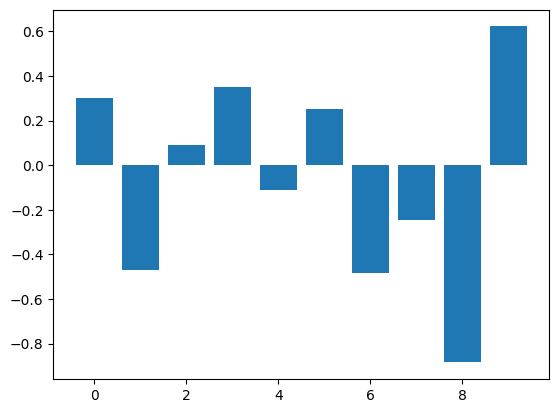

In [11]:
# Feed it wrong answers
def index_of(fn, ls):
    for i, item in enumerate(ls):
        if fn(item):
            return i

    raise StopIteration


def get_first_mnist(mnist_i: int | None):
    if mnist_i is None:
        mnist_sample = t.zeros(1, 3, 64, 32)
    else:
        mnist_sample_idx = index_of(lambda label: label == mnist_i, mnist_test.targets)
        mnist_sample = mnist_to_domino(mnist_test.data[mnist_sample_idx].unsqueeze(0))

    return mnist_sample


def get_first_cifar(cifar_i: int | None):
    if cifar_i is None:
        cifar_sample = t.zeros(1, 3, 64, 32)
    else:
        cifar_sample_idx = index_of(lambda label: label == cifar_i, cifar_test.targets)
        cifar_sample = cifar_to_domino(t.tensor(cifar_test.data[cifar_sample_idx]).unsqueeze(0))

    return cifar_sample

def test_domino(mnist_i: int | None, cifar_i: int | None, model: nn.Module):
    mnist_sample = get_first_mnist(mnist_i)
    cifar_sample = get_first_cifar(cifar_i)

    domino = mnist_sample + cifar_sample

    return domino, model(domino)

domino, preds = test_domino(None, 0, model)

# plt.imshow(einops.rearrange(domino[0].int(), "c h w -> h w c"))
# plt.show()

plt.bar(np.arange(10), preds[0].detach().numpy())

In [10]:
def domino_confusion_matrix(model: nn.Module, mnist_test, cifar_test):
    confusion_matrix = t.zeros(11, 11, 10) # 10+1 MNIST classes x 10+1 CIFAR classes x 10 predictions

    classes = [None, *range(10)]

    for mnist_i, cifar_i in tqdm(itertools.product(classes, classes), "Computing hyperconfusion", total=11 * 11):
        if mnist_i is None and cifar_i is None:
            continue
        elif mnist_i is None:
            cifar_samples = cifar_test.data[t.tensor(cifar_test.targets) == cifar_i]
            mnist_samples = t.zeros(cifar_samples.shape[0], 28, 28)
        elif cifar_i is None:
            mnist_samples = mnist_test.data[t.tensor(mnist_test.targets) == mnist_i]
            cifar_samples = t.zeros(mnist_samples.shape[0], 32, 32, 3)
        else:
            mnist_samples = mnist_test.data[t.tensor(mnist_test.targets) == mnist_i]
            cifar_samples = cifar_test.data[t.tensor(cifar_test.targets) == cifar_i]

        mnist_samples = mnist_to_domino(mnist_samples)
        cifar_samples = cifar_to_domino(cifar_samples)

        dominoes = create_dominoes_for_class(mnist_samples, cifar_samples, 0, 0)[0]
        batches = [dominoes[i:i+64] for i in range(0, len(dominoes), 64)]
        
        n_samples = dominoes.shape[0]

        # Iterate over batches of 64 dominoes and sum the predictions

        i, j = mnist_i + 1 if mnist_i is not None else 0, cifar_i + 1 if cifar_i is not None else 0
        for batch in batches:        
            preds = model(batch)
            confusion_matrix[i, j] += preds.sum(dim=0)

        confusion_matrix[i, j] /= n_samples

    return confusion_matrix

confusion_matrix = domino_confusion_matrix(model, mnist_test, cifar_test)

Computing hyperconfusion:   0%|          | 0/121 [00:00<?, ?it/s]

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_10179/2732718807.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mnist_samples = mnist_test.data[t.tensor(mnist_test.targets) == mnist_i]
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_10179/89674851.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cifar = t.tensor(cifar).float()
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_10179/2732718807.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mnist_samples = mnist_test.data[t.tensor(mnist_test.ta

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_10179/89674851.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cifar = t.tensor(cifar).float()


Plotting entries:   0%|          | 0/121 [00:00<?, ?it/s]

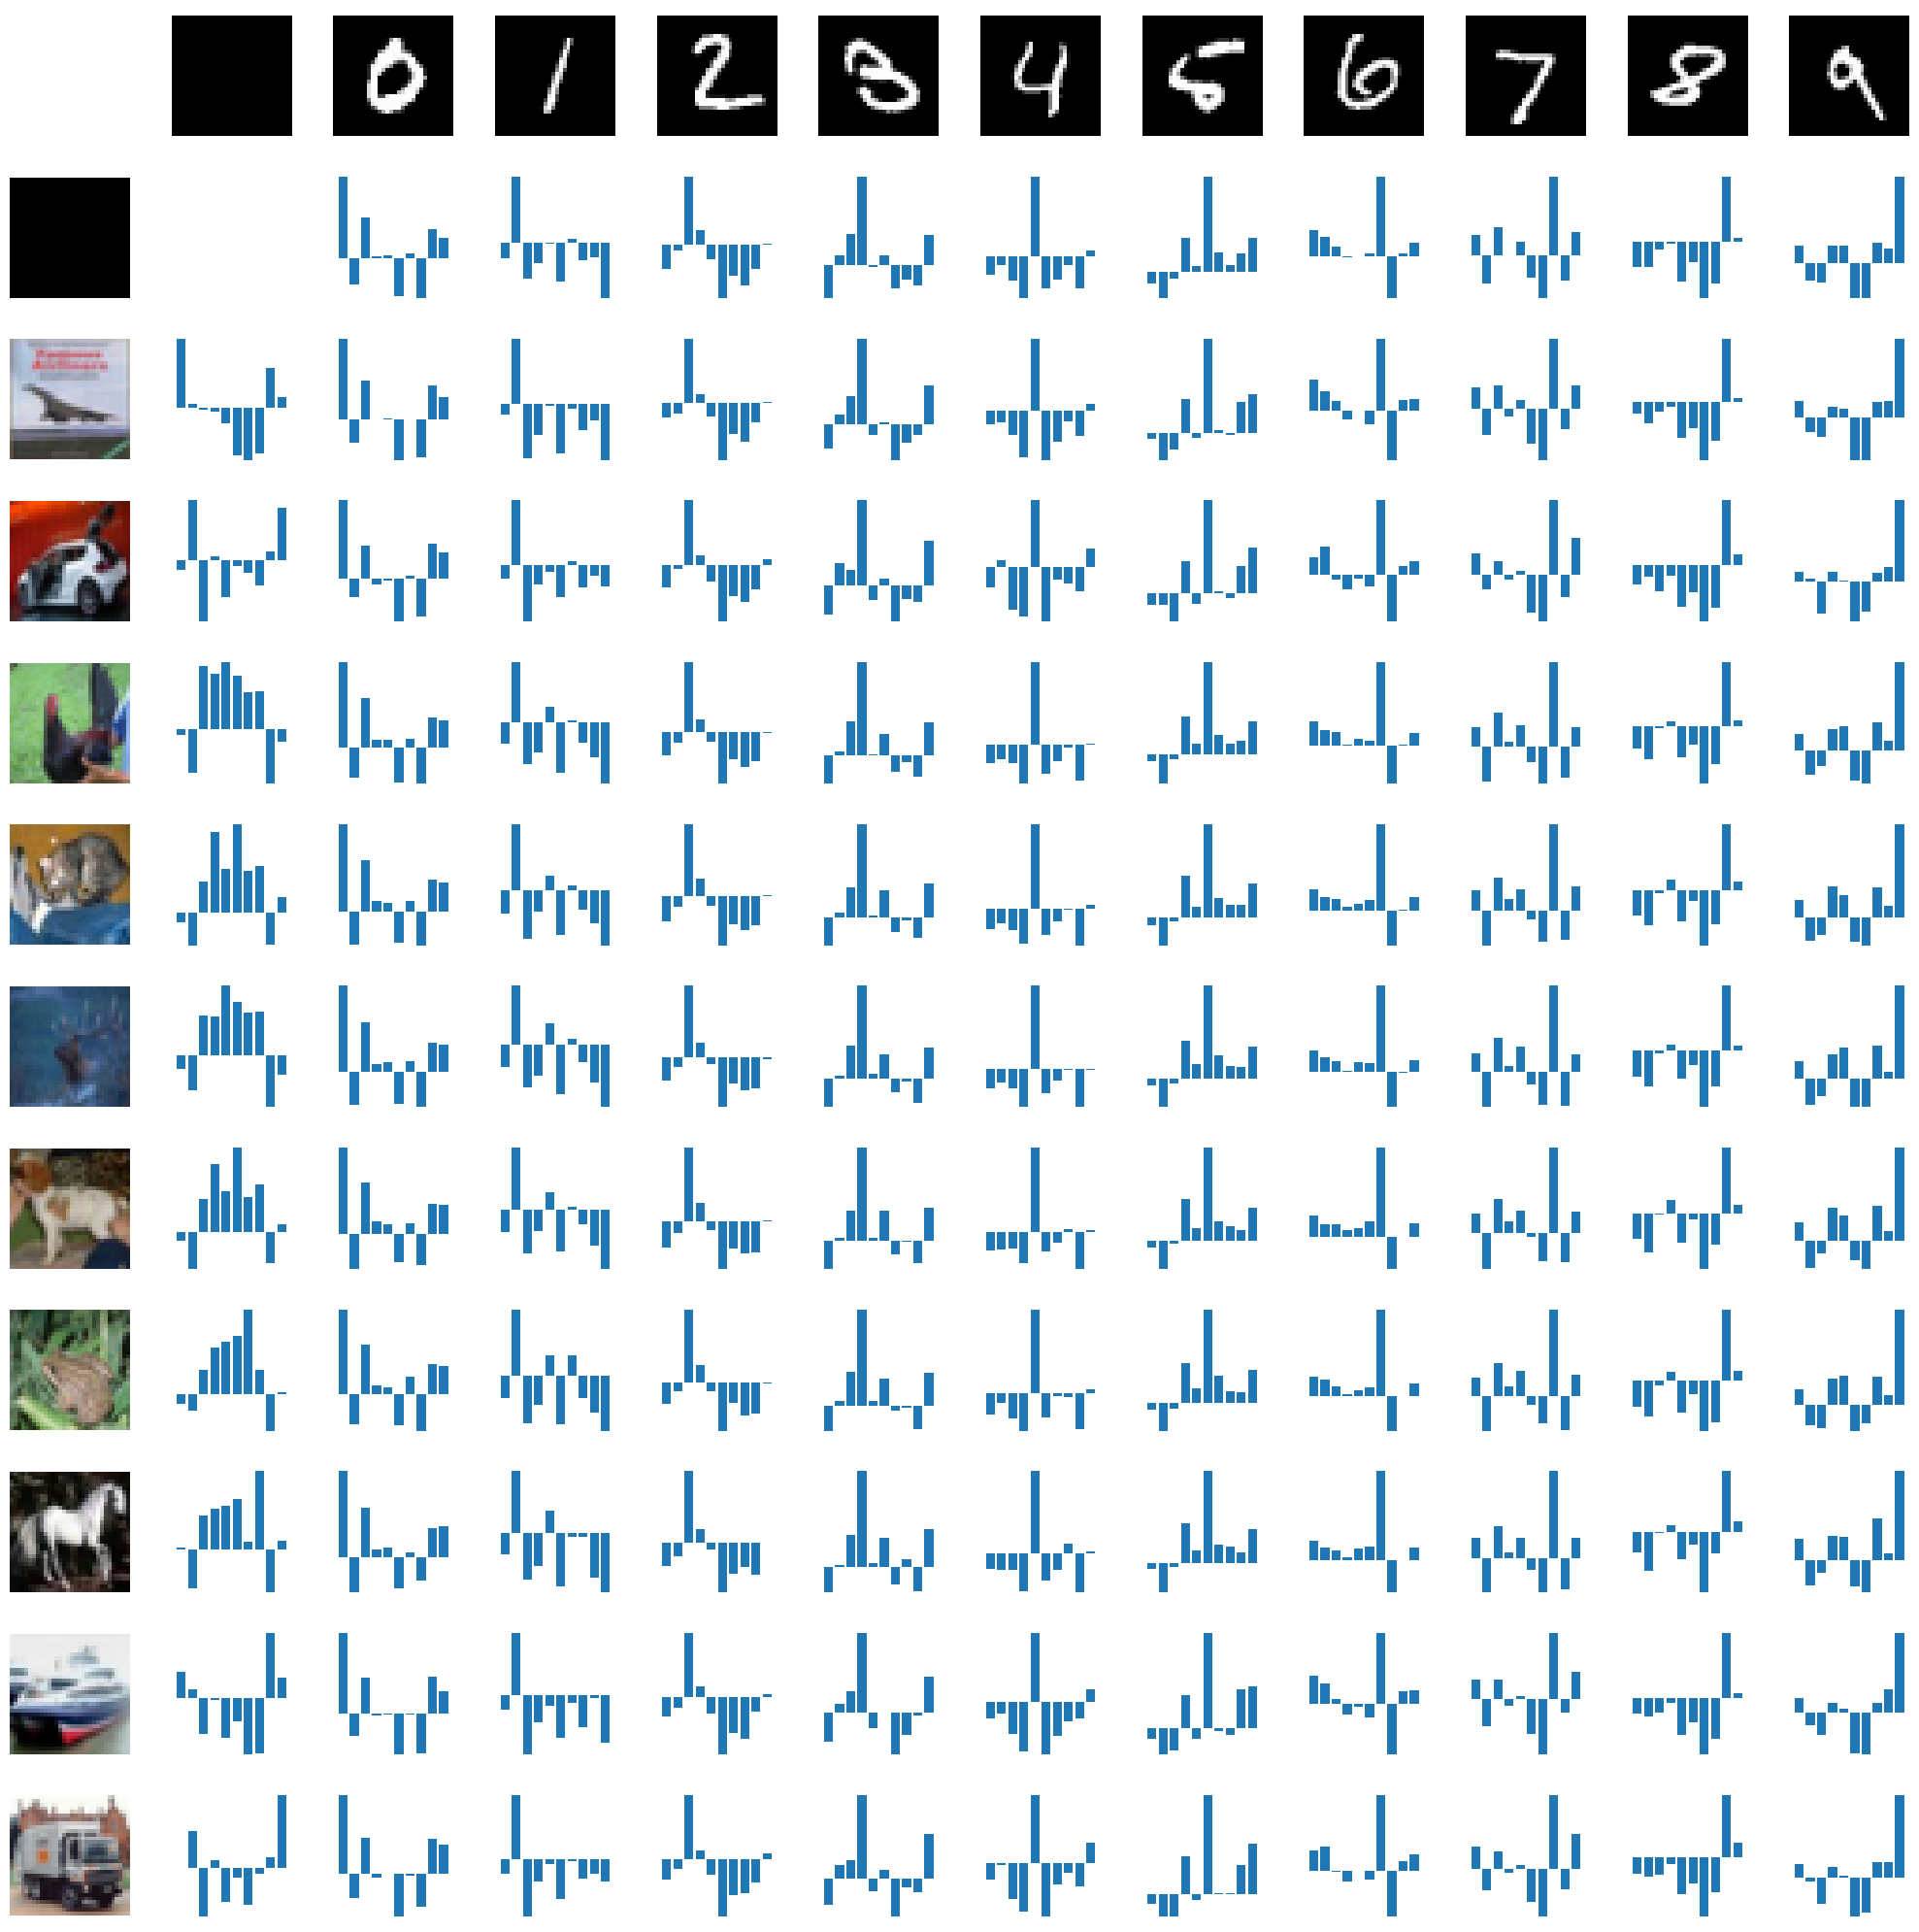

In [11]:
def plot_domino_confusion_matrix(confusion_matrix: TensorType[11, 11, 10]):

    fig, axes = plt.subplots(12, 12, figsize=(20, 20))
    fig.tight_layout(pad=0)
    axes[0][0].axis("off")

    classes = [None, *range(10)]

    for i, lbl in enumerate(classes):
        mnist = einops.rearrange(get_first_mnist(lbl)[0].int().detach().numpy(), "c h w -> h w c")
        axes[0][i+1].imshow(mnist[:32])
        axes[0][i+1].axis("off")

        cifar = einops.rearrange(get_first_cifar(lbl)[0].int().detach().numpy(), "c h w -> h w c")
        axes[i+1][0].imshow(cifar[32:])
        axes[i+1][0].axis("off")

    for i, j in tqdm(itertools.product(range(1, 12), range(1, 12)), desc="Plotting entries", total=11 * 11):
        axes[j][i].axis("off")
        axes[j][i].bar(np.arange(10), confusion_matrix[i-1, j-1].detach().numpy())

    plt.show()

plot_domino_confusion_matrix(confusion_matrix)

In [102]:
def sweep_prevalence(name: str, description: str):
    sweep = {
        'method': 'grid',
        'parameters': {
            'batch_size': {'value': 64},
            'epochs': {'value': 5},
            'lr': {'value': 0.001},
            'seed': {'min': 0, 'max': 5},
            
        },
        'name': name,
        'description': description
    }
    sweep_id = wandb.sweep(sweep=sweep, project='dominoes')
    wandb.agent(sweep_id, function=train, count=5 * )

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)